In [ ]:
!pip install -q langchain-groq
!pip install -q langgraph

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.9/134.9 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.3/153.3 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.9/43.9 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.1/56.1 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.7/216.7 kB 16.8 MB/s eta 0:00:00


In [ ]:
!pip install grandalf

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.8/41.8 kB 3.1 MB/s eta 0:00:00


In [ ]:
from google.colab import userdata
import os
os.environ["GROQ_API_KEY"] = userdata.get("GROQ_API_KEY")
os.environ["LANGSMITH_API_KEY"] = userdata.get("LANGSMITH_API_KEY")
os.environ["LANGSMITH_TRACING_V2"] = "true"
os.environ["LANGSMITH_PROJECT"] = "zingle"

In [237]:
from langchain_groq import ChatGroq
from langgraph.graph import StateGraph, START, END
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage

llm = ChatGroq(model="openai/gpt-oss-120b")
llm_multimodal = ChatGroq(model="meta-llama/llama-4-maverick-17b-128e-instruct")

In [99]:
import io
import base64

In [ ]:
from sqlalchemy import create_engine, text

def run_query(connection_string: str, query: str):
    engine = create_engine(connection_string)

    with engine.connect() as conn:
        result = conn.execute(text(query))

        if result.returns_rows:
            # Convert rows to list of dictionaries
            rows = [dict(row._mapping) for row in result]
            return rows
        else:
            return {"rows_affected": result.rowcount}

In [ ]:
import sqlite3
import json
from sqlalchemy import create_engine, inspect

# Path to the existing SQLite database
db_path = "manufacturing.sqlite"  # use the path to your downloaded file
conn_str = f"sqlite:///{db_path}"

# Using SQLAlchemy to inspect schema
engine = create_engine(conn_str)
inspector = inspect(engine)

schema = {}
for table in inspector.get_table_names():
    cols = inspector.get_columns(table)
    schema[table] = [
        {
            "name": c["name"],
            "type": str(c["type"]),
            "nullable": c["nullable"],
            "default": c["default"],
        }
        for c in cols
    ]

# Save schema to JSON
with open("schema.json", "w", encoding="utf-8") as f:
    json.dump(schema, f, indent=2)

print("Connection string for your agents:", conn_str)
print("Schema saved to schema.json")

Connection string for your agents: sqlite:///manufacturing.sqlite
Schema saved to schema.json


In [ ]:
with open("schema.json", "r") as f:
    schema = json.load(f)

In [213]:
from typing_extensions import TypedDict
import matplotlib.pyplot as plt

class GraphGenState(TypedDict):
    query: str
    conn_str: str
    schema: str
    sql: str
    table: dict
    graph_code: str
    graph_data: str
    graph_caption:str

def sql_gen(GraphGenState):
    messages = [SystemMessage("""
    You are an sql code generating agent. You are given a natural language query based on a SQL database.
    Your task is to write an SQL query that will answer the given natural language query. Only respond in a structured form with the SQL query only.
    IMPORTANT, generate only single sql query, multiple queries not allowed.
    No english text or 'Here's your code'. Just plain SQL. Not even stuff like "three backticks sql."
    """)]
    messages.append(HumanMessage(f"Here is the natural language query: {GraphGenState['query']}. Here is the database schema in JSON format: {GraphGenState['schema']}"))
    result = llm.invoke(messages)
    GraphGenState["sql"] = result.content
    return GraphGenState

def sql_exec(GraphGenState):
    conn_str = GraphGenState["conn_str"]
    sql = GraphGenState["sql"]
    output = run_query(conn_str, sql)
    GraphGenState["table"] = output
    return GraphGenState

def graph_code_gen(GraphGenState):
    messages = [SystemMessage("""
    You are a matplotlib code generating agent. You are given a table. Think of a graph that can be plotted on the given table.
    Your task is to write python matplotlib code that can be executed out of the box.
    No english text or 'Here's your code'. Just plain python. Remember your output will be executed as it is, so generate responsibly.
    IMPORTANT, make sure to save the figure in a variable named fig. Make sure to add plt.close(fig) at the end.
    No english text or 'Here's your code'. Just plain python. Not even stuff like "three backticks python."
    """)]
    messages.append(HumanMessage(f"Here is the query: {GraphGenState['query']}. Here is the table: {str(GraphGenState['table'])}"))
    result = llm.invoke(messages)
    GraphGenState["graph_code"] = result.content
    return GraphGenState

def graph_gen(GraphGenState):
   local_vars={}
   exec(GraphGenState["graph_code"],{},local_vars)
   graph_fig = local_vars.get("fig") or local_vars.get("ax") or None
   buf = io.BytesIO()
   graph_fig.savefig(buf, format='png', bbox_inches='tight')
   GraphGenState["graph_data"] = base64.b64encode(buf.getvalue()).decode('utf-8')
   return GraphGenState

def caption_gen(GraphGenState):
    messages = [SystemMessage("""
        You are a caption and summary generating agent. You are given a graph and a schema for an SQL DB.
        Your task is to completely analyze the graph and
        1. Generate a caption for the graph, short and concise. not more than 10 words.
        2. Analyze the graph and provide insights on it in form of a short summary.
        IMPORTANT, return data in the form of a tuple like this ( <graph_caption> , <graph_analysis> ). Only return the tuple and nothing else. Make sure the tuple is properly formatted. Double check your output before sending it.
    """)]
    messages.append(HumanMessage(
        content = [
            {"type": "text", "text": f"Here is the schema: {str(GraphGenState['schema'])}"},
            {
                    "type": "image_url",
                    "image_url": {"url": f"data:image/jpeg;base64,{GraphGenState["graph_data"]}"},
                }
        ]
    ))
    result = llm_multimodal.invoke(messages)
    GraphGenState["graph_caption"] = eval(result.content)
    return GraphGenState

In [258]:
from IPython.display import Image, display
# from langgraph import Node, Graph
builder = StateGraph(GraphGenState)
builder.add_node("SQL Generator", sql_gen)
builder.add_node("SQL Executor", sql_exec)
builder.add_node("Graph Code Generator", graph_code_gen)
builder.add_node("Graph Executor", graph_gen)
builder.add_node("Graph Caption", caption_gen)

builder.add_edge(START, "SQL Generator")
builder.add_edge("SQL Generator", "SQL Executor")
builder.add_edge("SQL Executor", "Graph Code Generator")
builder.add_edge("Graph Code Generator", "Graph Executor")
builder.add_edge("Graph Executor", "Graph Caption")
builder.add_edge("Graph Caption", END)

g = builder.compile()
g.get_graph().print_ascii()

      +-----------+      
      | __start__ |      
      +-----------+      
            *            
            *            
            *            
    +---------------+    
    | SQL Generator |    
    +---------------+    
            *            
            *            
            *            
    +--------------+     
    | SQL Executor |     
    +--------------+     
            *            
            *            
            *            
+----------------------+ 
| Graph Code Generator | 
+----------------------+ 
            *            
            *            
            *            
   +----------------+    
   | Graph Executor |    
   +----------------+    
            *            
            *            
            *            
    +---------------+    
    | Graph Caption |    
    +---------------+    
            *            
            *            
            *            
      +---------+        
      | __end__ |        
      +-----

In [215]:
from sqlalchemy.exc import OperationalError
query = "find the number of unique employees in every department and make a pie chart"
try:
    out = g.invoke({
        "query": query,
        "conn_str": conn_str,
        "schema": str(schema)
    })
except OperationalError as e:
    print("Schema mismatch error.")

In [216]:
class SummaryGenState(TypedDict):
    schema: str
    summary: str

In [217]:
def summary_gen(SummaryGenState):
  messages = [SystemMessage("""
    You are a summary generating agent. You are given a schema for an sql db, you have to ananlyze all the tables in that schema and give a 2 line description for all the tables
    .Along with that, describe the relation between different tables taking into account their columns and titles and give a 1 line description of all the columns in every table
    as well in the format, column: description. The generation should be plain comprehensible text
    """)]
  messages.append(HumanMessage(f"Here is the schema: {str(SummaryGenState['schema'])}"))
  result = llm.invoke(messages)
  SummaryGenState["summary"] = result.content
  return SummaryGenState

In [218]:
builder = StateGraph(SummaryGenState)
builder.add_node("Summary Generator", summary_gen)

builder.add_edge(START, "Summary Generator")
builder.add_edge("Summary Generator", END)

g_s = builder.compile()
g_s.get_graph().print_ascii()

    +-----------+      
    | __start__ |      
    +-----------+      
          *            
          *            
          *            
+-------------------+  
| Summary Generator |  
+-------------------+  
          *            
          *            
          *            
     +---------+       
     | __end__ |       
     +---------+       


In [219]:
class KPIGenState(TypedDict):
    schema: str
    goals:str
    kpi: list

In [220]:
def kpi_gen(KPIGenState):
  messages = [SystemMessage("""
  You are a KPI generating agent. You have been given the schema for the datatbase of a company along with the summary of the database and the goals of the company.
  Your task is to generate the 3 most relevant kpis based on these factors
  IMPORTANT, return the kpis in the form of a list of strings. Only return the list and nothing else."
    """)]
  messages.append(HumanMessage(f"Here is the schema: {str(KPIGenState['schema'])}"))
  messages.append(HumanMessage(f"Here are the goals: {str(KPIGenState['goals'])}"))
  result=llm.invoke(messages)
  KPIGenState["kpi"]=eval(result.content)
  return KPIGenState

In [221]:
builder= StateGraph(KPIGenState)
builder.add_node("KPI Generator", kpi_gen)

builder.add_edge(START, "KPI Generator")
builder.add_edge("KPI Generator", END)

g_k = builder.compile()
g_k.get_graph().print_ascii()

  +-----------+    
  | __start__ |    
  +-----------+    
        *          
        *          
        *          
+---------------+  
| KPI Generator |  
+---------------+  
        *          
        *          
        *          
   +---------+     
   | __end__ |     
   +---------+     


In [229]:
def generate_list_graph(list_obj, query):
    list_graph = []
    for h in list_obj:
        try:
            list_graph.append(g.invoke({
                "query": query + f"{h}",
                "conn_str": conn_str,
                "schema": str(schema)
            }))
        except OperationalError as e:
            print("Schema mismatch error.")
    return list_graph

In [235]:
goals = "increasing sales and profit."
res = g_k.invoke({"schema": schema,
                  "goals": goals})

In [239]:
list_graph = generate_list_graph(res["kpi"], "For the given KPI, plot a graph highlighting the specific datapoints")

In [238]:
res["kpi"]

['Total Revenue (sum of Sales.total_amount)',
 'Net Profit Margin (Finance.net_profit ÷ Finance.total_revenue)',
 'Sales Growth Rate (percentage change in Sales.total_amount over successive periods)']

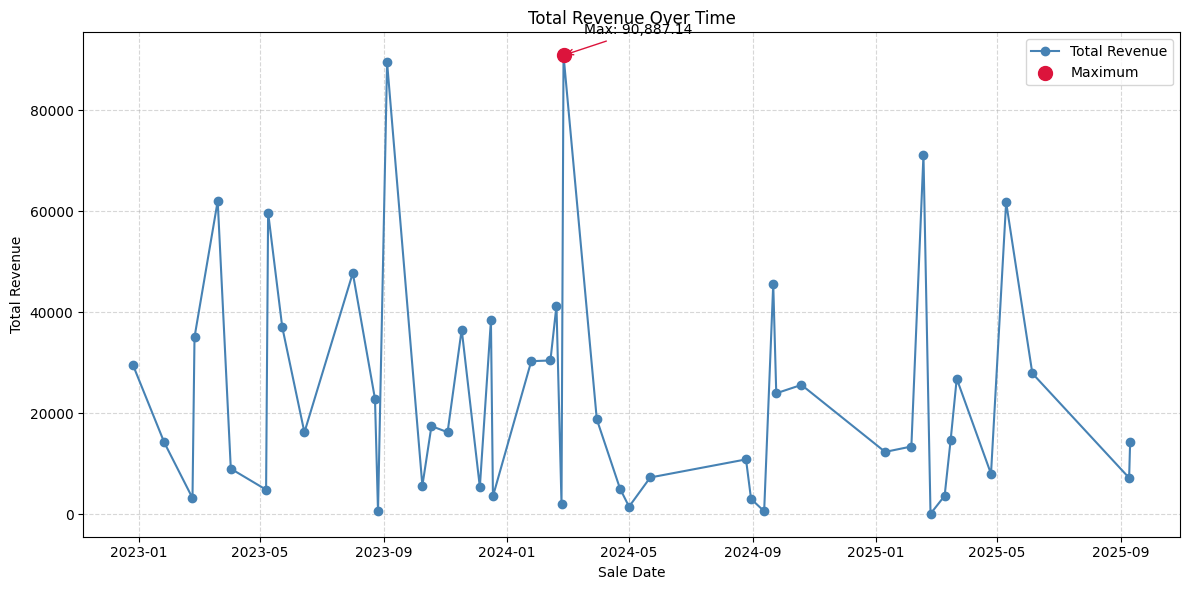

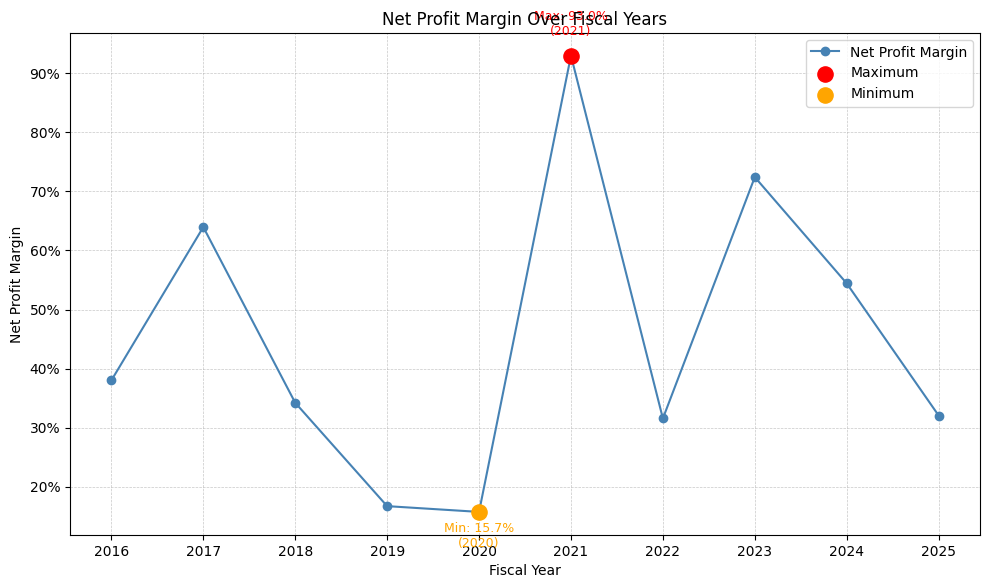

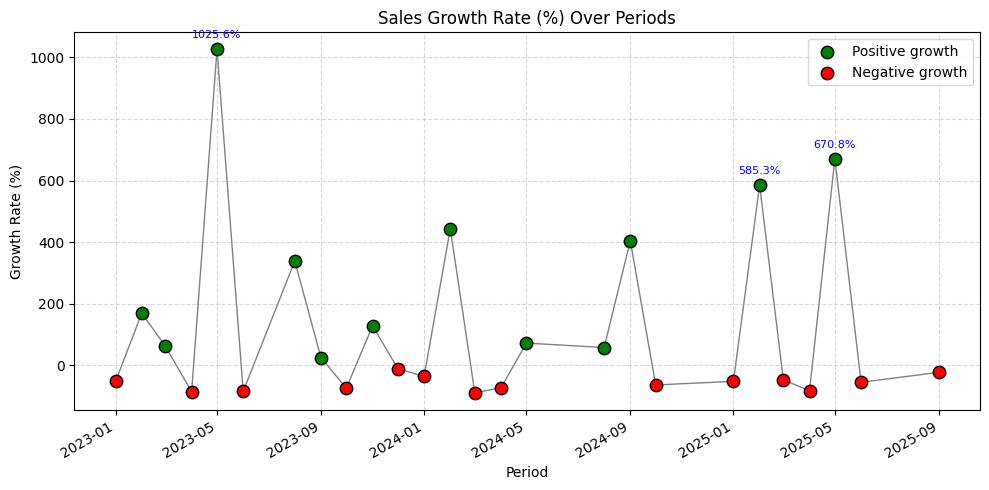

In [245]:
from PIL import Image
for lg in list_graph:
    image = Image.open(io.BytesIO(base64.b64decode(lg["graph_data"])))
    display(image)

In [247]:
class RelevantGraphGenState(TypedDict):
    schema: str
    relevant_graph_names: list
    relevant_graph: list

In [251]:
def relevant_graph_name_gen(RelevantGraphGenState):
    messages = [SystemMessage("""
    You are an advisor agent that advises what all graphs are relevant for a given database. You are given a SQL schema for a database with multiple tables that may or may not have relationships between them.
    Your goal is to generate ideas about graphs that may be relevant to show on a database dashboard. These ideas must be in english form. They will be later passed to an SQL query generator so double check what you propose can even exist or not.
    Be creative with your ideas, use different types of charts like line, bar, histogram, pie, boxplot, heatmaps. Whatever is relevant.
    Output format: You have to output a python list of strings. Your output will be executed as it is in a python evaluator so make sure to return only a python list.
    """)]
    messages.append(HumanMessage(f"Here is the schema: {str(RelevantGraphGenState['schema'])}"))
    result = llm.invoke(messages)
    RelevantGraphGenState["relevant_graph_names"] = eval(result.content)
    return RelevantGraphGenState

In [252]:
builder = StateGraph(RelevantGraphGenState)
builder.add_node("Relevant Graph Name Generator", relevant_graph_name_gen)

builder.add_edge(START, "Relevant Graph Name Generator")
builder.add_edge("Relevant Graph Name Generator", END)
g_dashboard_graphs = builder.compile()
g_dashboard_graphs.get_graph().print_ascii()

          +-----------+            
          | __start__ |            
          +-----------+            
                *                  
                *                  
                *                  
+-------------------------------+  
| Relevant Graph Name Generator |  
+-------------------------------+  
                *                  
                *                  
                *                  
           +---------+             
           | __end__ |             
           +---------+             


In [253]:
res = g_dashboard_graphs.invoke({
    "schema": schema
})

In [259]:
dashboard_graphs = generate_list_graph(res["relevant_graph_names"][2:6], "For the given title, plot a graph")

<string>:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
<string>:51: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior


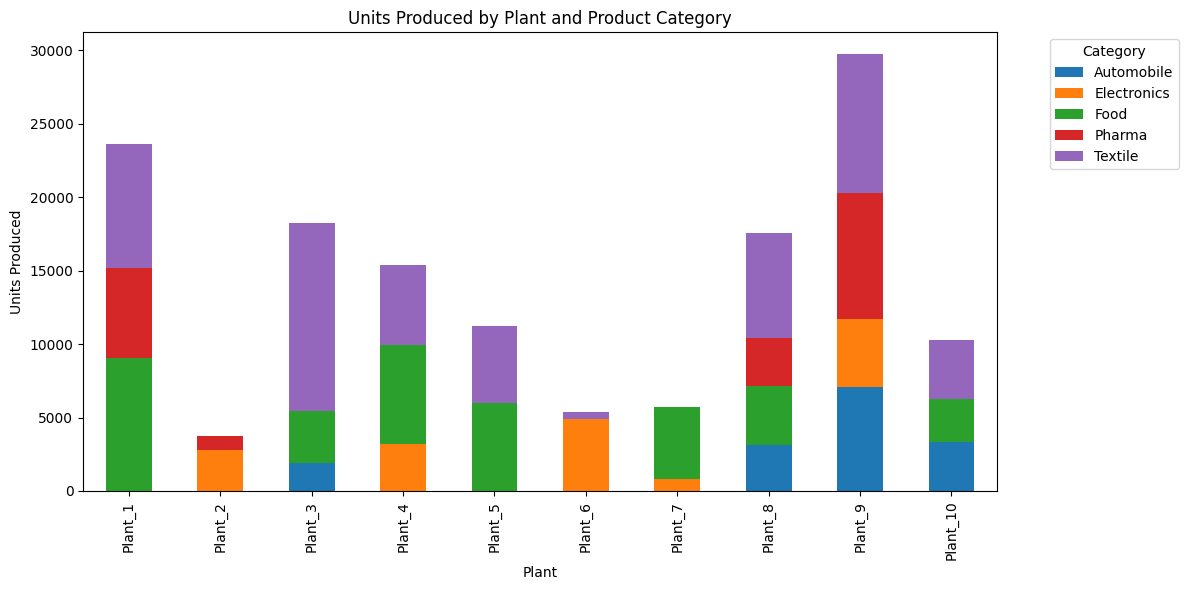

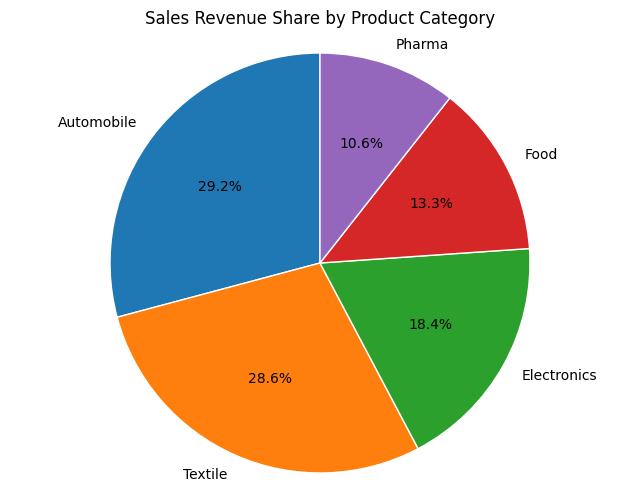

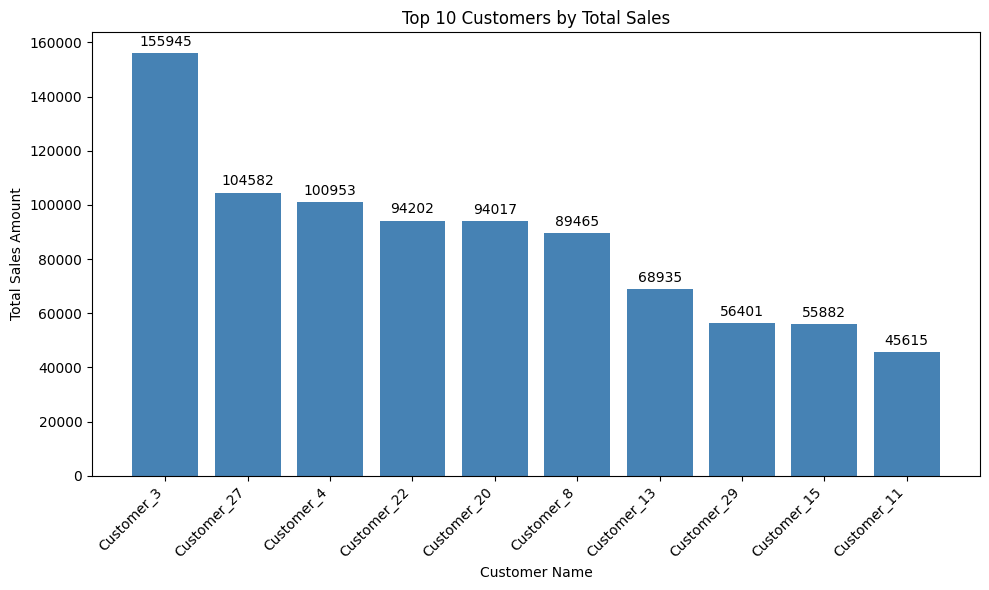

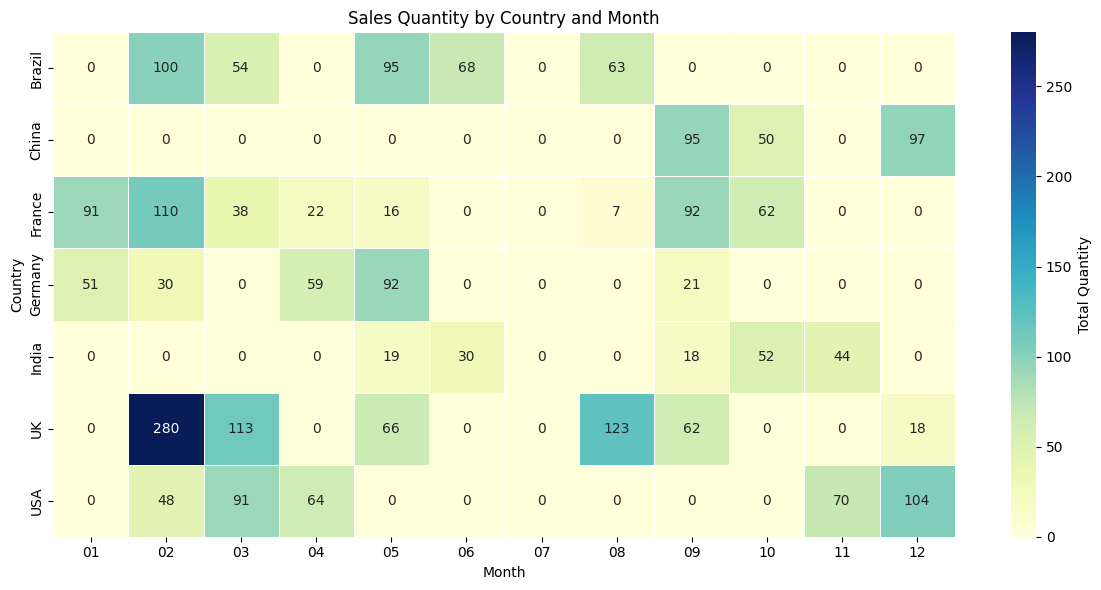

In [261]:
from PIL import Image
for lg in dashboard_graphs:
    image = Image.open(io.BytesIO(base64.b64decode(lg["graph_data"])))
    display(image)